In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
from datetime import datetime
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv() 
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow

In [2]:
def split_time_series_data_percentage(
    df: pd.DataFrame,
    target_column: str,
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a time series DataFrame into training, validation, and testing sets (70%, 20%, 10%).

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        target_column (str): The name of the target column to separate from the features.

    Returns:
        Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
            - X_train (pd.DataFrame): Training features (70% of data).
            - y_train (pd.Series): Training target values.
            - X_val (pd.DataFrame): Validation features (20% of data).
            - y_val (pd.Series): Validation target values.
            - X_test (pd.DataFrame): Testing features (10% of data).
            - y_test (pd.Series): Testing target values.
    """
    # Sort the DataFrame by date
    df_sorted = df.sort_values("pickup_hour")

    # Calculate the split indices
    train_end = int(len(df) * 0.5)
    val_end = int(len(df) * 0.8)

    # Split the data into training, validation, and testing sets
    train_data = df_sorted[:train_end].reset_index(drop=True)
    val_data = df_sorted[train_end:val_end].reset_index(drop=True)
    test_data = df_sorted[val_end:].reset_index(drop=True)

    # Separate features (X) and target (y) for all three sets
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_val = val_data.drop(columns=[target_column])
    y_val = val_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df.head(5)
df.shape

(87620, 675)

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data_percentage(df, target_column="target")

In [5]:
print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (43810, 674)
Validation set shape: (26286, 674)
Test set shape: (17524, 674)


In [6]:
def average_rides_last_4_weeks(X: pd.DataFrame) -> pd.DataFrame:
    last_4_weeks_columns = [
            f"rides_t-{7*24}",  # 1 week ago
            f"rides_t-{14*24}", # 2 weeks ago
            f"rides_t-{21*24}", # 3 weeks ago
            f"rides_t-{28*24}"  # 4 weeks ago
        ]

        # Ensure the required columns exist in the test DataFrame
    for col in last_4_weeks_columns:
        if col not in X.columns:
            raise ValueError(f"Missing required column: {col}")

    # Calculate the average of the last 4 weeks
    X["average_rides_last_4_weeks"] = X[last_4_weeks_columns].mean(axis=1)

    return X


add_feature_average_rides_last_4_weeks = FunctionTransformer(
    average_rides_last_4_weeks, validate=False
)


class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_["hour"] = X_["pickup_hour"].dt.hour
        X_["day_of_week"] = X_["pickup_hour"].dt.dayofweek

        return X_.drop(columns=["pickup_hour", "pickup_location_id"])

add_temporal_features = TemporalFeatureEngineer()

In [7]:
pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features,
    lgb.LGBMRegressor()
)

In [8]:
def tune_parameter(param_name, param_range, X, y, pipeline, fixed_params):
    best_score = float('inf')
    best_value = None
    scores = []
    for value in param_range:
        params = {**fixed_params, f"lgbmregressor__{param_name}": value}
        model = pipeline.set_params(**params)
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        mean_score = -np.mean(cv_scores)
        scores.append(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_value = value
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Validation MAE')
    plt.title(f'{param_name} vs Validation MAE')
    plt.show()
    
    print(f"Best {param_name}: {best_value}")
    return best_value, best_score


In [9]:
# Define the pipeline
pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features,
    lgb.LGBMRegressor()
)

In [10]:
# Initial fixed parameters
fixed_params = {
    'lgbmregressor__objective': 'regression',
    'lgbmregressor__metric': 'mae',
    'lgbmregressor__verbose': -1,
    'lgbmregressor__random_state': 42
}

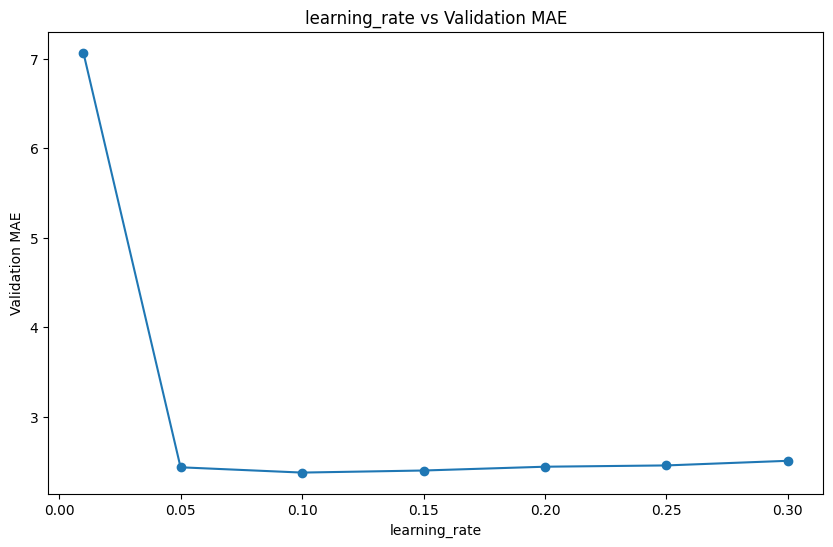

Best learning_rate: 0.1


In [11]:
# Tune learning rate
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
best_lr, _ = tune_parameter('learning_rate', learning_rates, X_train, y_train, pipeline, fixed_params)
fixed_params['lgbmregressor__learning_rate'] = best_lr

In [12]:
# Final model with tuned parameters
learning_rate_pipeline = pipeline.set_params(**fixed_params)
learning_rate_pipeline.fit(X_train, y_train)

# Evaluate on test set
test_pred = learning_rate_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, test_pred)
print(f"Final Test MAE: {test_mae}")
print("Best Parameters:", fixed_params)

Final Test MAE: 3.2463319918117515
Best Parameters: {'lgbmregressor__objective': 'regression', 'lgbmregressor__metric': 'mae', 'lgbmregressor__verbose': -1, 'lgbmregressor__random_state': 42, 'lgbmregressor__learning_rate': 0.1}


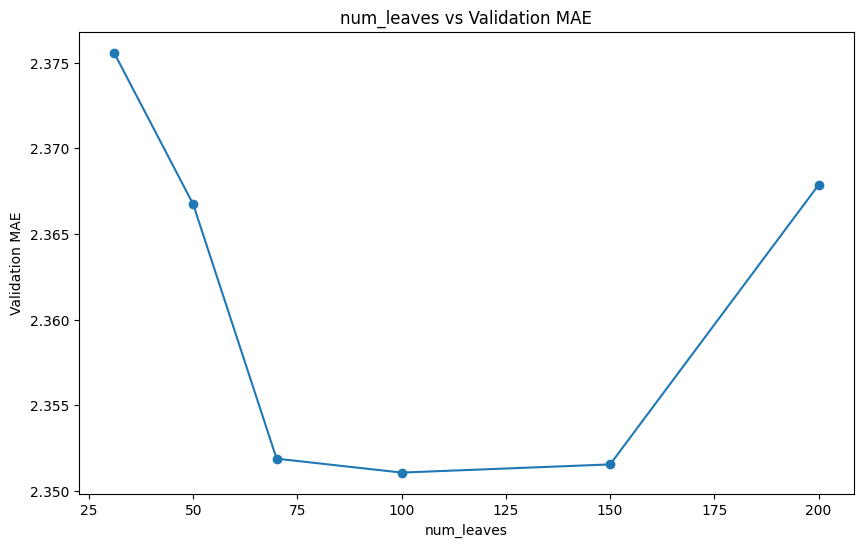

Best num_leaves: 100


In [13]:
# Tune num_leaves
num_leaves_range = [31, 50, 70, 100, 150, 200]
best_leaves, _ = tune_parameter('num_leaves', num_leaves_range, X_train, y_train, pipeline, fixed_params)
fixed_params['lgbmregressor__num_leaves'] = best_leaves

In [14]:
leaves_pipeline = pipeline.set_params(**fixed_params)
leaves_pipeline.fit(X_train, y_train)

# Evaluate on test set
test_pred = leaves_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, test_pred)
print(f"Final Test MAE: {test_mae}")
print("Best Parameters:", fixed_params)

Final Test MAE: 3.268429664477281
Best Parameters: {'lgbmregressor__objective': 'regression', 'lgbmregressor__metric': 'mae', 'lgbmregressor__verbose': -1, 'lgbmregressor__random_state': 42, 'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__num_leaves': 100}


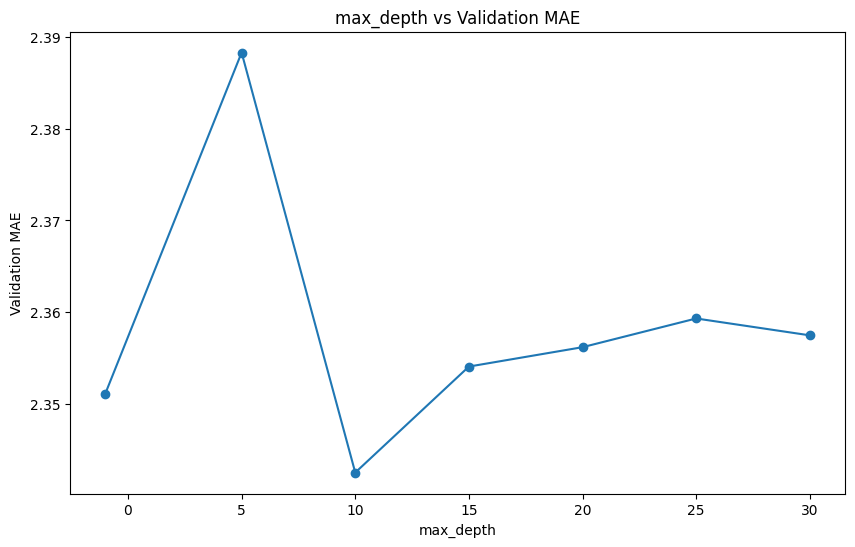

Best max_depth: 10


In [15]:
# Tune max_depth
max_depth_range = [-1, 5, 10, 15, 20, 25, 30]
best_depth, _ = tune_parameter('max_depth', max_depth_range, X_train, y_train, pipeline, fixed_params)
fixed_params['lgbmregressor__max_depth'] = best_depth

In [16]:
depth_pipeline = pipeline.set_params(**fixed_params)
depth_pipeline.fit(X_train, y_train)

# Evaluate on test set
test_pred = depth_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, test_pred)
print(f"Final Test MAE: {test_mae}")
print("Best Parameters:", fixed_params)

Final Test MAE: 3.2549585743103666
Best Parameters: {'lgbmregressor__objective': 'regression', 'lgbmregressor__metric': 'mae', 'lgbmregressor__verbose': -1, 'lgbmregressor__random_state': 42, 'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__num_leaves': 100, 'lgbmregressor__max_depth': 10}


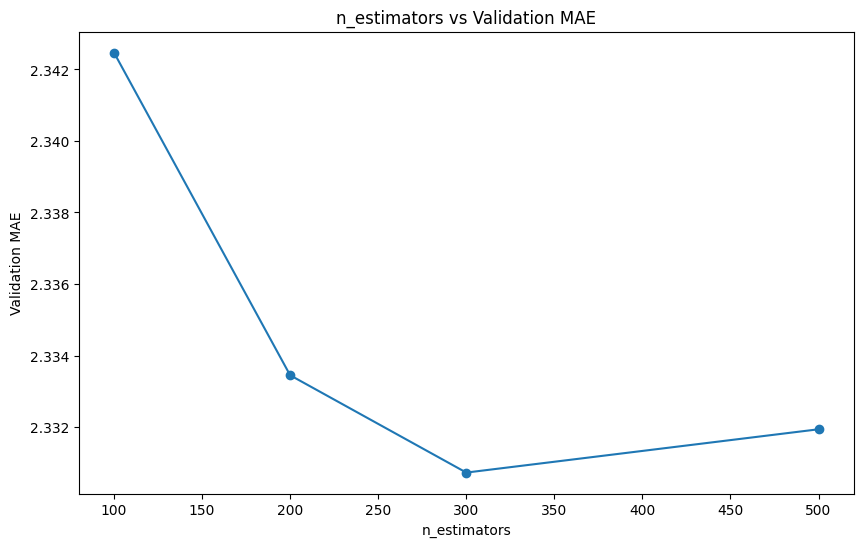

Best n_estimators: 300


In [17]:
# Tune n_estimators
n_estimators_range = [100, 200, 300, 500]
best_estimators, _ = tune_parameter('n_estimators', n_estimators_range, X_train, y_train, pipeline, fixed_params)
fixed_params['lgbmregressor__n_estimators'] = best_estimators

In [18]:
n_estimator_pipeline = pipeline.set_params(**fixed_params)
n_estimator_pipeline.fit(X_train, y_train)

# Evaluate on test set
test_pred = n_estimator_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, test_pred)
print(f"Final Test MAE: {test_mae}")
print("Best Parameters:", fixed_params)

Final Test MAE: 3.227478214001624
Best Parameters: {'lgbmregressor__objective': 'regression', 'lgbmregressor__metric': 'mae', 'lgbmregressor__verbose': -1, 'lgbmregressor__random_state': 42, 'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__num_leaves': 100, 'lgbmregressor__max_depth': 10, 'lgbmregressor__n_estimators': 300}


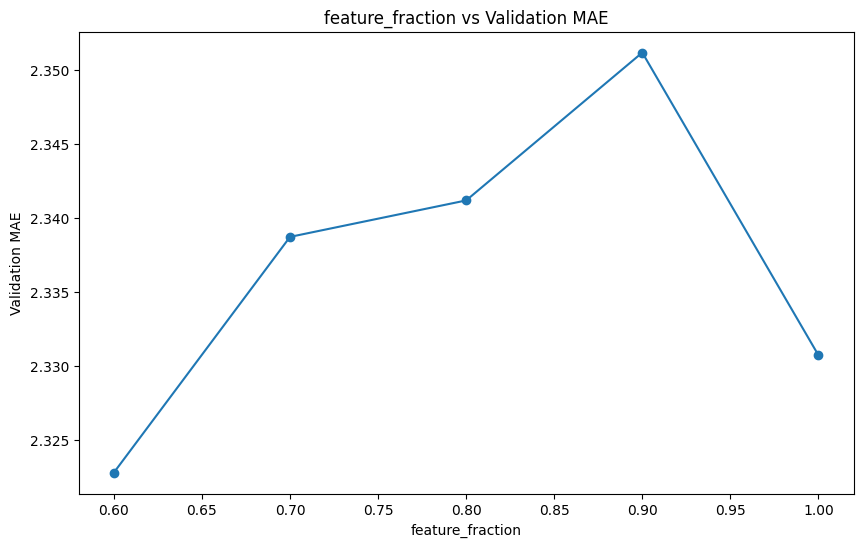

Best feature_fraction: 0.6


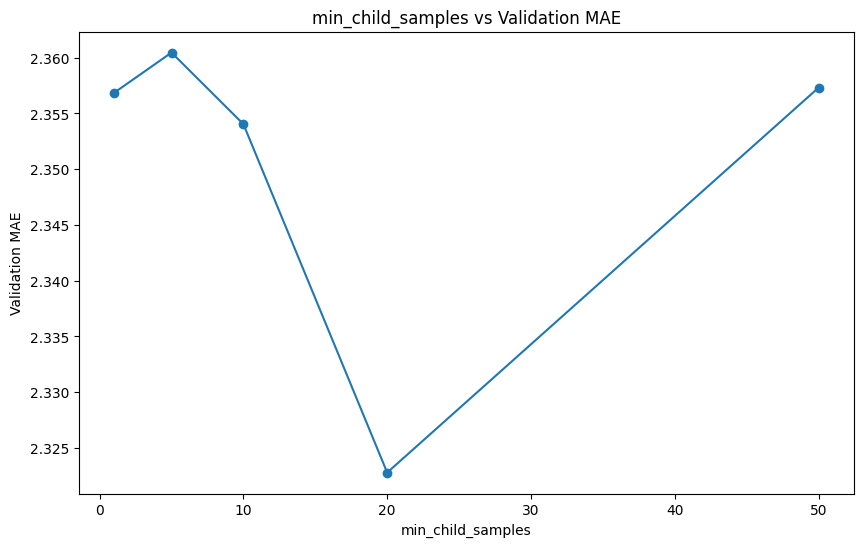

Best min_child_samples: 20


In [19]:
# Fine-tune other parameters
feature_fraction_range = [0.6, 0.7, 0.8, 0.9, 1.0]
best_feature_fraction, _ = tune_parameter('feature_fraction', feature_fraction_range, X_train, y_train, pipeline, fixed_params)
fixed_params['lgbmregressor__feature_fraction'] = best_feature_fraction

min_child_samples_range = [1, 5, 10, 20, 50]
best_min_child_samples, _ = tune_parameter('min_child_samples', min_child_samples_range, X_train, y_train, pipeline, fixed_params)
fixed_params['lgbmregressor__min_child_samples'] = best_min_child_samples

In [20]:
# Final model with tuned parameters
final_pipeline = pipeline.set_params(**fixed_params)
final_pipeline.fit(X_train, y_train)

# Evaluate on test set
test_pred = final_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, test_pred)
print(f"Final Test MAE: {test_mae}")
print("Best Parameters:", fixed_params)

Final Test MAE: 3.248876330168013
Best Parameters: {'lgbmregressor__objective': 'regression', 'lgbmregressor__metric': 'mae', 'lgbmregressor__verbose': -1, 'lgbmregressor__random_state': 42, 'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__num_leaves': 100, 'lgbmregressor__max_depth': 10, 'lgbmregressor__n_estimators': 300, 'lgbmregressor__feature_fraction': 0.6, 'lgbmregressor__min_child_samples': 20}
